# 
References:
* [Forecasting: Principles and Practice](https://otexts.com/fpp2/)
* [statsmodels.org](https://www.statsmodels.org/dev/examples/notebooks/generated/exponential_smoothing.html)
* [LightGBM](https://lightgbm.readthedocs.io/en/stable/Parameters-Tuning.html)

## Generate Data: Linear trend with a cyclic pattern and random noise

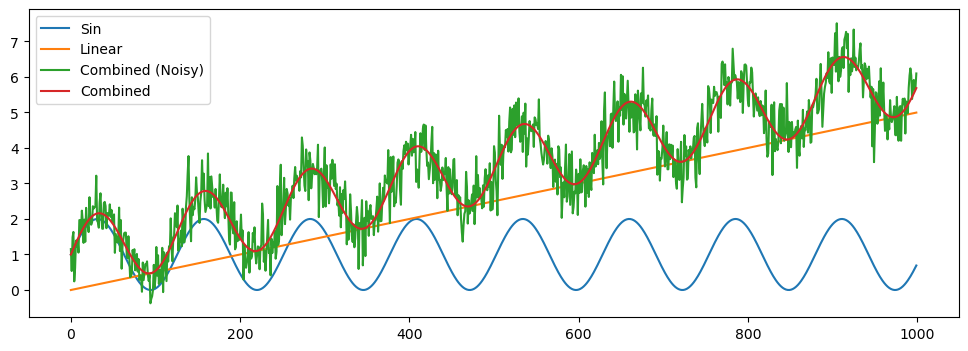

In [36]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
from statsmodels.tsa.arima.model import ARIMA
import lightgbm as lgb

sin = 1+np.sin(np.arange(1000)*.05)
linear = np.arange(1000)*.005
combined = sin + linear

rng = np.random.default_rng(42)
noisy_data = combined + rng.normal(scale=0.5, size=len(combined))

# Split the data into train and test sets
train_size = int(len(combined) * 0.8)
train, test = combined[:train_size], combined[train_size:]

plt.figure(figsize=(12, 4))
plt.plot(sin, label='Sin')
plt.plot(linear, label='Linear')
plt.plot(noisy_data, label='Combined (Noisy)')
plt.plot(combined, label='Combined')
plt.legend()
plt.show()

# LightGBM
We can turn the forecasting data into tabular form by creating lag features.

Tree based models cannot make predictions outside of the training data. Below we see the result of this by finding that the model won't predict a value higher than what was previously observed

,data,t_1,t_2,t_3,t_4
0,1.000000,NaN,NaN,NaN,NaN
1,1.054979,1.000000,NaN,NaN,NaN
2,1.109833,1.054979,1.000000,NaN,NaN
3,1.164438,1.109833,1.054979,1.000000,NaN
4,1.218669,1.164438,1.109833,1.054979,1.0


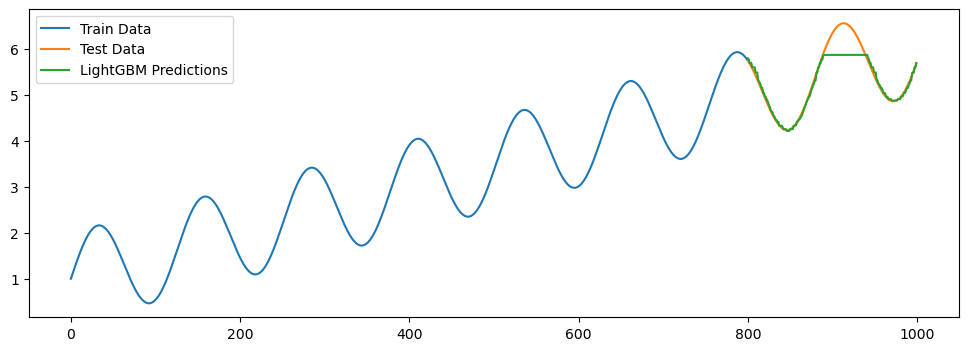

In [22]:
df = pd.DataFrame({'data':combined})
for lag in range(1, 5):
    df[f't_{lag}'] = df['data'].shift(lag)

X = df.drop('data', axis=1)
y = df['data']

X_train, X_test = X[:train_size], X[train_size:] 
y_train, y_test = y[:train_size], y[train_size:] 

display(df.head())

params = {'bagging_fraction': 0.5, 'boosting_type': 'gbdt', 'feature_fraction': 0.9, 'lambda_l1': 0, 'lambda_l2': 0.2, 'learning_rate': 0.2, 'metric': 'l2', 'min_gain_to_split': 0.01, 'num_leaves': 20, 'objective': 'regression', 'verbose': -1}
lgb_train = lgb.Dataset(X_train, y_train)
gbm = lgb.train(params, lgb_train)
predictions = gbm.predict(X_test)

plt.figure(figsize=(12, 4))
plt.plot(train, label='Train Data')
plt.plot(np.arange(train_size, len(combined)), test, label='Test Data')
plt.plot(np.arange(train_size, len(combined)), predictions, label=f'LightGBM Predictions')
plt.legend()
plt.show()

In [6]:
# from sklearn.model_selection import GridSearchCV

# param_grid = {
#     'boosting_type': ['gbdt', 'dart'],
#     'metric': ['l2'],
#     'learning_rate': [0.05, 0.1, 0.2],
#     'num_leaves': [5, 10, 20, 40],
#     'feature_fraction': [0.5, 0.9, 0.95, 1],
#     'bagging_fraction': [0.5, 0.9, 0.95, 1],
#     'lambda_l1': [0, 0.1, 0.2],
#     'lambda_l2': [0, 0.1, 0.2],
#     'min_gain_to_split': [0.01, 0.1, 0.2],
#     'verbose': [-1]
# }

# gbm = lgb.LGBMRegressor()
# grid_search = GridSearchCV(estimator=gbm, param_grid=param_grid, scoring='neg_mean_squared_error')
# grid_search.fit(X_train, y_train)

# print("Best parameters found by grid search are:", grid_search.best_params_)

Best parameters found by grid search are: {'bagging_fraction': 0.5, 'boosting_type': 'gbdt', 'feature_fraction': 0.9, 'lambda_l1': 0, 'lambda_l2': 0.2, 'learning_rate': 0.2, 'metric': 'l2', 'min_gain_to_split': 0.01, 'num_leaves': 20, 'objective': 'regression', 'verbose': -1}


# Exponential Smoothing:
$ S_t = \alpha  y_t + (1 - \alpha) S_{t-1} $, where
- $ S_t $ is the smoothed value at time $ t $
- $ y_t $ is the actual value at time $ t $
- $ \alpha $ is the smoothing parameter, $ 0 \leq \alpha \leq 1 $

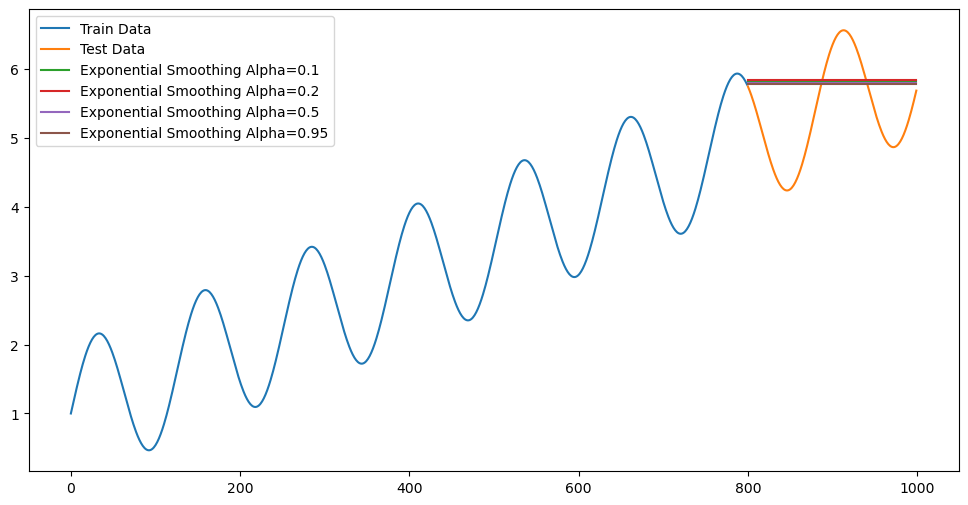

In [21]:
plt.figure(figsize=(12, 6))
plt.plot(train, label='Train Data')
plt.plot(np.arange(train_size, len(combined)), test, label='Test Data')

for alpha in [0.1, 0.2, 0.5, 0.95]:
    exp_model = SimpleExpSmoothing(train).fit(smoothing_level=alpha, optimized=False)
    exp_smoothing_forecast = exp_model.forecast(len(test))
    plt.plot(np.arange(train_size, len(combined)), exp_smoothing_forecast, label=f'Exponential Smoothing Alpha={alpha}')

plt.legend()
plt.show()

## Exponential smoothing with seasonality (Holt-Winters)
This is data dependent. For example, if you have daily data and a weekly trend in the data, then the seasonality parameter will be 7.

Here I find the seasonality by looking at when the sin function repeats.

Average distance between peaks: 125.67


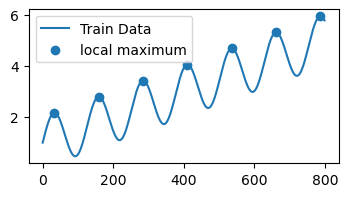

In [154]:
peaks = []
for i, n in enumerate(train):
    if i == 0 or i >= len(train)-1:
        pass
    else:
        if n > train[i-1] and n > train[i+1]:
            peaks.append(i)

print(f"Average distance between peaks: {round(sum(list(map(lambda x1, x2: x2-x1, peaks[:-1], peaks[1:]))) / len(peaks[:-1]), 2)}")

plt.figure(figsize=(4, 2))
plt.plot(train, label='Train Data')
plt.scatter(peaks, train[peaks], label='local maximum')
plt.legend()
plt.show()

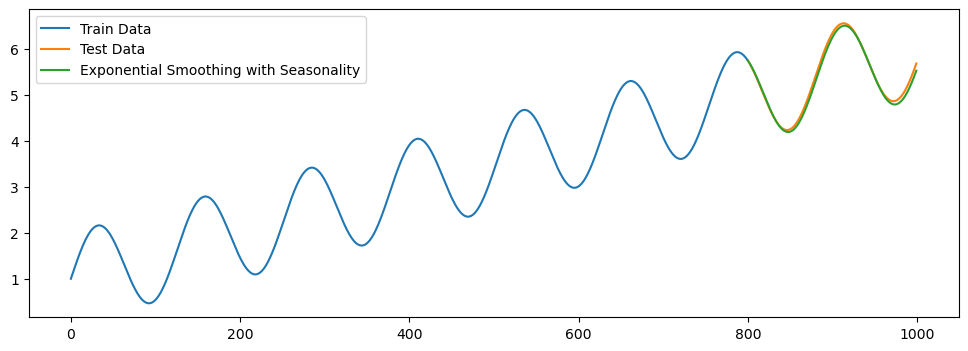

In [155]:
plt.figure(figsize=(12, 4))
plt.plot(train, label='Train Data')
plt.plot(np.arange(train_size, len(combined)), test, label='Test Data')

exp_model = ExponentialSmoothing(train,
                seasonal_periods=126,
                trend="add",
                seasonal="add").fit()
exp_smoothing_forecast = exp_model.forecast(len(test))
plt.plot(np.arange(train_size, len(combined)), exp_smoothing_forecast, label=f'Exponential Smoothing with Seasonality')
plt.legend()
plt.show()

## Model decomposition

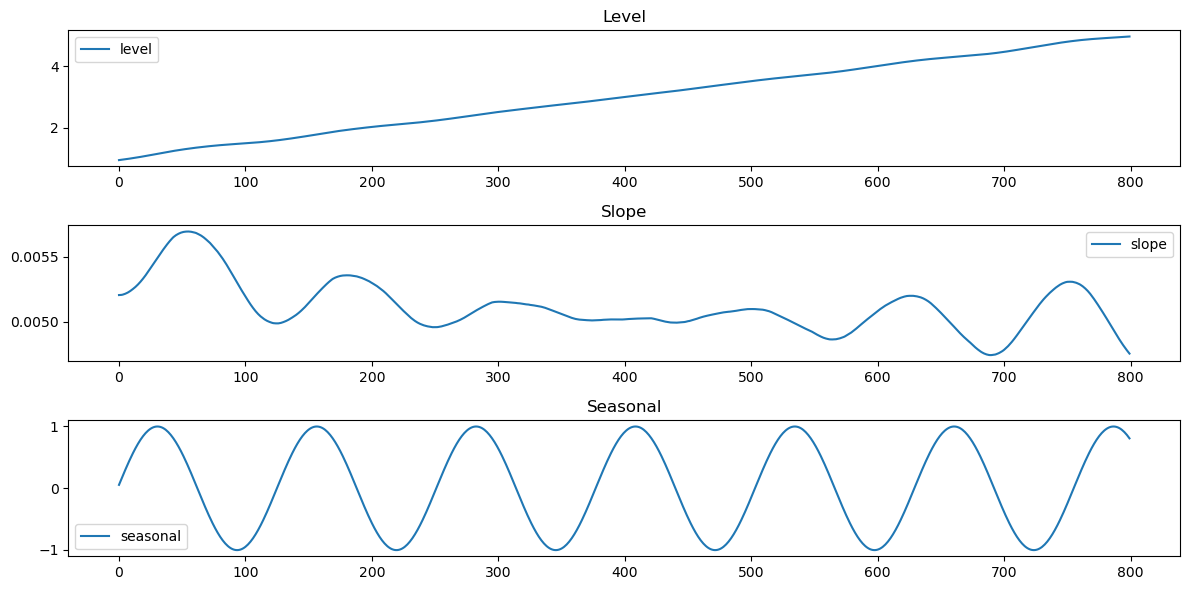

In [157]:
states = pd.DataFrame(
    np.c_[exp_model.level, exp_model.trend, exp_model.season],
    columns=["level", "slope", "seasonal"]
)
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 6))
states[["level"]].plot(ax=ax1, title="Level")
states[["slope"]].plot(ax=ax2, title="Slope")
states[["seasonal"]].plot(ax=ax3, title="Seasonal")
plt.tight_layout()
plt.show()

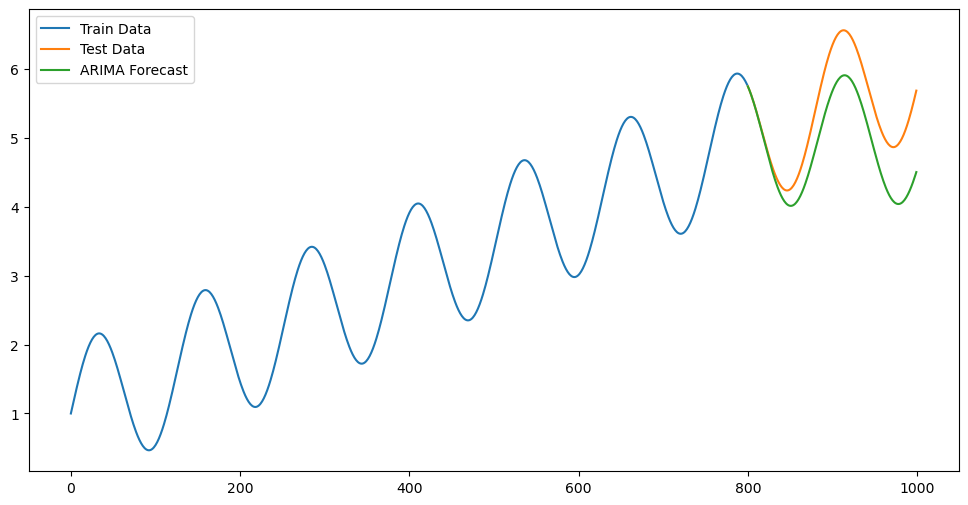

In [159]:
# arima_model = ARIMA(train, order=(1, 1, 1))
arima_model = ARIMA(train, order=(2, 1, 1))
arima_fit = arima_model.fit(method_kwargs={"warn_convergence": False})
arima_forecast = arima_fit.forecast(len(test))

plt.figure(figsize=(12, 6))
plt.plot(train, label='Train Data')
plt.plot(np.arange(train_size, len(combined)), test, label='Test Data')
plt.plot(np.arange(train_size, len(combined)), arima_forecast, label='ARIMA Forecast')
plt.legend()
plt.show()

## SARIMAX(p, d, q)x(P, D, Q, s)


ARIMA
$ \phi(B)(1 - B)^d y_t = \theta(B) \varepsilon_t $, where
- $ p $ is the order of the autoregressive (AR) part
- $ d $ is the degree of differencing
- $ q $ is the order of the moving average (MA) part
- $ B $ is the backshift operator, $ B^k y_t = y_{t-k} $
- $ \phi(B) $ is the AR polynomial, $ \phi(B) = 1 - \phi_1 B - \phi_2 B^2 - \ldots - \phi_p B^p $
- $ \theta(B) $ is the MA polynomial, $ \theta(B) = 1 + \theta_1 B + \theta_2 B^2 + \ldots + \theta_q B^q $
- $ \varepsilon_t $ is the white noise error term at time $ t $


Parameters:
* **AutoRegressive (p)**: Relationship between an observation and a certain number of lagged observations (previous time steps). The parameter p determines the number of lag observations included in the model.
* **Integrated (d)**: Order of differencing required to make the series stationary. Differencing is the transformation of a time series to remove trends and seasonality, and d is the number of times the differencing operation is performed.
* **Moving Average (q)**: Relationship between an observation and a residual error from a moving average model applied to lagged observations. The parameter q specifies the number of terms.

Seasonal components:
* **Seasonal AR (P)**: Similar to the AR but apply to the seasonal component of the series. The parameter P specifies the number of seasonal autoregressive terms.
* **Seasonal differencing order (D)**: How many seasonal differences are needed to make the series stationary.
* **Seasonal MA (Q)**: MA for the seasonal differences. Q specifies the number of seasonal moving average terms.
* **Seasonal period (s)**: Length of the seasonal cycle. E.g. s=12 for monthly data with an annual cycle.
* **Exogenous variables (X)**: External variables that influence the forecast but are not predicted by the model. They can include any variable thought to affect the dependent variable, such as economic indicators, weather conditions, etc.

/Users/jordanbarker/miniconda3/envs/py311/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


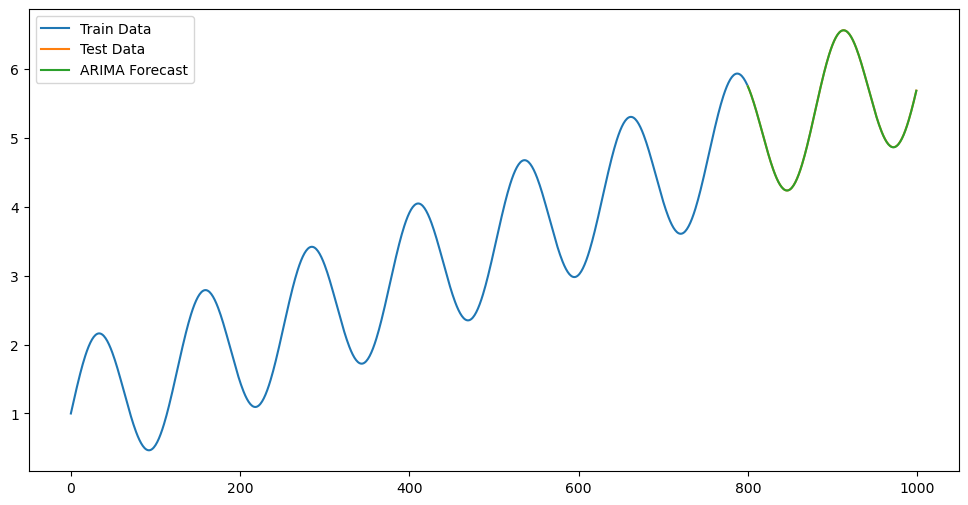

In [161]:
# arima_model = ARIMA(train, order=(1, 1, 1))
arima_model = ARIMA(train, order=(1, 1, 1), seasonal_order=(1, 1, 1, 126))
arima_fit = arima_model.fit(method_kwargs={"warn_convergence": False})
arima_forecast = arima_fit.forecast(len(test))

plt.figure(figsize=(12, 6))
plt.plot(train, label='Train Data')
plt.plot(np.arange(train_size, len(combined)), test, label='Test Data')
plt.plot(np.arange(train_size, len(combined)), arima_forecast, label='ARIMA Forecast')
plt.legend()
plt.show()

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.30738D+08    |proj g|=  5.24229D+13


 This problem is unconstrained.



At iterate    5    f=  4.33743D+01    |proj g|=  1.36278D+04

At iterate   10    f=  3.56048D+00    |proj g|=  6.62664D+02

At iterate   15    f= -1.06381D+00    |proj g|=  2.65629D+01

At iterate   20    f= -1.32502D+00    |proj g|=  2.77580D+00

At iterate   25    f= -4.44983D+00    |proj g|=  7.94985D+01

At iterate   30    f= -6.17641D+00    |proj g|=  6.45943D+01



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     33    143      3     0     0   3.962D+01  -6.176D+00
  F =  -6.1764170296188876     

ABNORMAL_TERMINATION_IN_LNSRCH                              


/Users/jordanbarker/miniconda3/envs/py311/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.


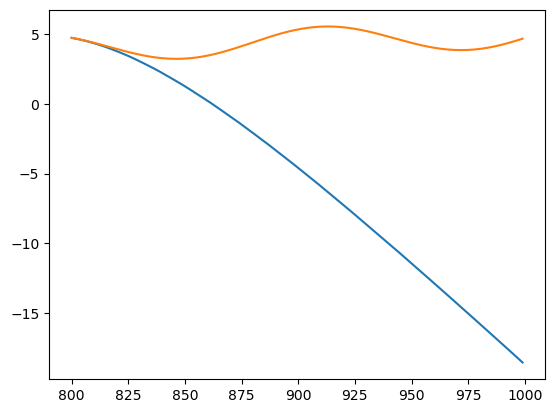

In [35]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

sarimax_model = SARIMAX(train, order=(2, 1, 1), seasonal_order=(1, 1, 1, 12))
sarimax_fit = sarimax_model.fit()
sarimax_forecast = sarimax_fit.forecast(len(test))
plt.plot(np.arange(train_size, len(combined)), sarimax_forecast, label='SARIMAX Forecast')
plt.plot(np.arange(train_size, len(combined)), test, label='Test Data')


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.71189D+07    |proj g|=  2.71189D+12
  ys=-2.512E+01  -gs= 9.653E-01 BFGS update SKIPPED

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F


 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
/Users/jordanbarker/miniconda3/envs/py311/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


    4      3     62      3     1     0   1.309D+04  -8.697D+00
  F =  -8.6967851778906144     

ABNORMAL_TERMINATION_IN_LNSRCH                              



 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.


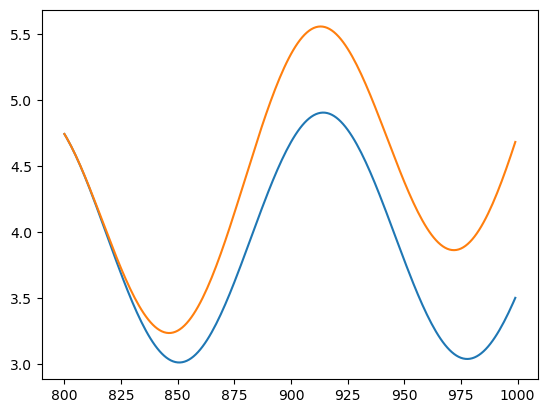

In [38]:
sarimax_model = SARIMAX(train, order=(2, 1, 1))
sarimax_fit = sarimax_model.fit()
sarimax_forecast = sarimax_fit.forecast(len(test))
plt.plot(np.arange(train_size, len(combined)), sarimax_forecast, label='SARIMAX Forecast')
plt.plot(np.arange(train_size, len(combined)), test, label='Test Data')

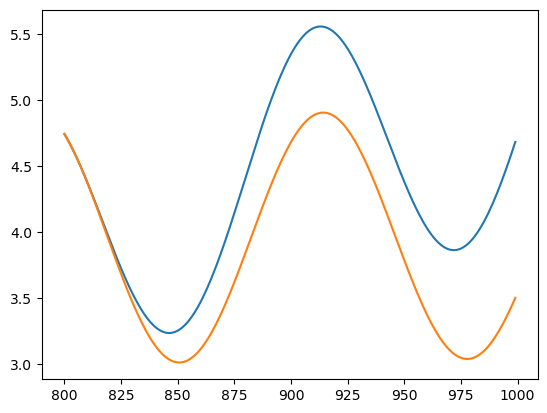

In [32]:
arima_model = ARIMA(train, order=(2, 1, 1))
arima_fit = arima_model.fit(method_kwargs={"warn_convergence": False})
arima_forecast = arima_fit.forecast(len(test))
plt.plot(np.arange(train_size, len(combined)), test, label='Test Data')
plt.plot(np.arange(train_size, len(combined)), arima_forecast, label='ARIMA Forecast')


# Box-Cox Transformation
Transforms the target variable so that data resembles a normal distribution which is assumed by many models.

Cons:
* Harder to interprete
* Usually gives the median of the forecast distribution when we revert the transformed data to its original scale.

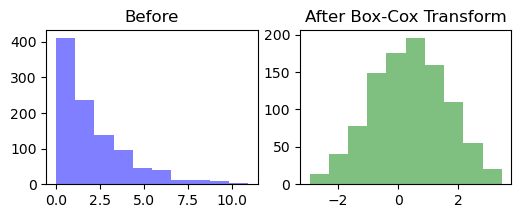

In [129]:
from scipy import stats

data = np.random.exponential(scale=2, size=1000)
plt.figure(figsize=(6, 2))
plt.subplot(1, 2, 1)
plt.hist(data, bins=10, alpha=0.5, color='blue')
plt.title("Before")

transformed_data, lambda_best = stats.boxcox(data)
plt.subplot(1, 2, 2)
plt.hist(transformed_data, bins=10, alpha=0.5, color='green')
plt.title("After Box-Cox Transform")
plt.show()